In [17]:
# Run the cell below if you want to have output of the cells on their side
# reload the page to get back to the default way.
# You can edit background colors below (change the hex #RGB values)
# Taken from:
# https://github.com/jupyter/notebook/issues/2897#issuecomment-442959381

In [1]:
%%html
<style>
#notebook-container {
    width: 100%;
    background-color: #111
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .output_wrapper {
    width: 50%;
    background-color: #333
}

.code_cell .input {
    width: 50%;
    background-color: #222
}
</style>

In [87]:
# To have plots in new windows.
# %matplotlib tk   

# To have interavtive plots inline in output.
%matplotlib notebook   

import time
from wandelscript.metamodel import Skill, register_builtin_func
from wandelscript.viewer import SkillViewer
from wbigeometry.core.algorithm.fillpattern import generate_path
import math
import numpy as np

import matplotlib.pyplot as plt
import open3d as o3d
import pickle

# specific funcions written for EFW project
from cameraRobotCalibration import *
from fillerDetection import *

# To autoreload imported libraries:    
%load_ext autoreload
%autoreload 2

from wandelpy.azurekinect2 import AzureKinect, Camera 
kinect = None
try:
    kinect = AzureKinect() 
    print("\n\nSuccess with connecting to camera.")
except:
    time.sleep(1)
    print("Camera couldn't be connected. Use the notebook with loading captures.")
    
print(3*'\n')
print("Defined parameters:")
print("Max depth (for cut off): ", maxDepth:=1500)
print("Max ir value (for cut off): ", maxIrValue:=800)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[2022-05-26 16:30:54.082] [critical] [t=157859] /home/patrick/development/3rdparty/Azure-Kinect-Sensor-SDK/src/usbcommand/usbcommand.c (365): find_libusb_device(). libusb device(s) are all unavalable. Is the device being used by another application?
[2022-05-26 16:30:54.082] [error] [t=157859] /home/patrick/development/3rdparty/Azure-Kinect-Sensor-SDK/src/depth_mcu/depth_mcu.c (68): usb_cmd_create(USB_DEVICE_DEPTH_PROCESSOR, device_index, NULL, &depthmcu->usb_cmd) returned failure in depthmcu_create()
[2022-05-26 16:30:54.082] [error] [t=157859] /home/patrick/development/3rdparty/Azure-Kinect-Sensor-SDK/src/sdk/k4a.c (133): depthmcu_create(index, &device->depthmcu) returned failure in k4a_device_open()
[2022-05-26 16:30:54.082] [error] [t=157859] /home/patrick/development/3rdparty/Azure-Kinect-Sensor-SDK/src/sdk/k4a.c (53): k4a_device_t_get_context(). Invalid k4a_device_t (nil)
[2022-05-26 16:30:54.

Exception ignored in: <function AzureKinect.__del__ at 0x7fd055f4d550>
Traceback (most recent call last):
  File "/home/erik/.cache/pypoetry/virtualenvs/wandelscript-RyiTJHvp-py3.8/lib/python3.8/site-packages/wandelpy/hardware/azurekinect.py", line 251, in __del__
    if self._is_connected:
AttributeError: 'AzureKinect' object has no attribute '_is_connected'


Camera couldn't be connected. Use the notebook with loading captures.




Defined parameters:
Max depth (for cut off):  1500
Max ir value (for cut off):  800


<IPython.core.display.Javascript object>


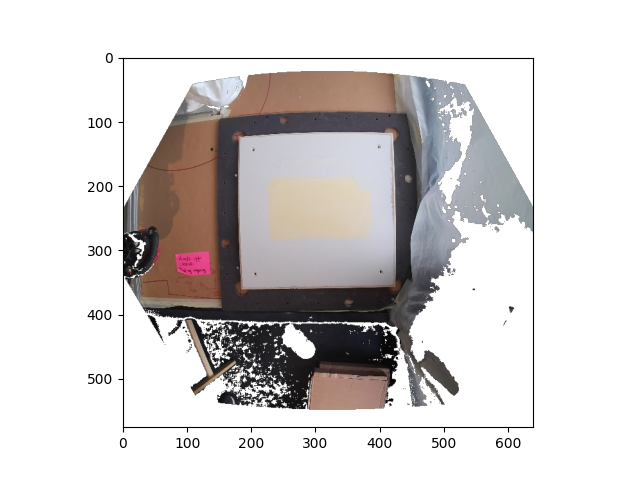

File 02_Tedlar_5.pkl saved.


In [74]:
#### Saving of the images:
# ------------------------------------------------------
# Save the captures:
# sCapture1
# sCapture2

itemNumber = 10
itemName = '02_Tedlar'
itemName = 'GFK'
itemName = '04_Tedlar_GFK'
itemName = '05_Cockpit'
itemName = '05_Cockpit_FS'  #front side with metal area lower. just 2 images

itemName = 'newName'
fileName = f'{itemName}_{itemNumber}.pkl'

with open(fileName, 'wb') as fileOut:
    listOfCaptures = [sCapture1, sCapture2]
    pickle.dump(listOfCaptures, fileOut)
    
print(f'File {fileName} saved.')    
# ------------------------------------------------------

<IPython.core.display.Javascript object>


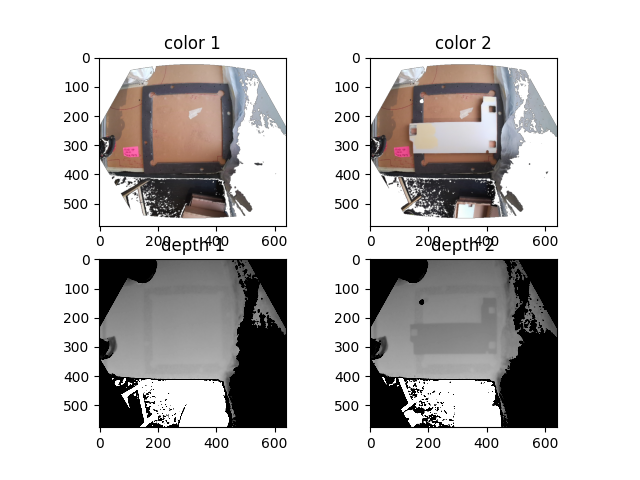

File 05_Cockpit_5.pkl loaded.


In [59]:
# Load the captures:
fileLoad = 'test2.pkl'   # 2 completely different images
fileLoad = 'set2.pkl'    # Images with one object difference - direciton into a corner
fileLoad = 'cell1.pkl'    # Image in the cell - Bumpy metal piece
fileLoad = 'cell2.pkl'    # Image in the cell - Thick wooden piece
fileLoad = 'cell3.pkl'    # Image in the cell - Thin wooden plank
fileLoad = 'cell4.pkl'    # Image in the cell - Thin wooden plank - at an angle

# V2: means the sCapture was updated - to have color_depth2d and depth3d
fileLoad = 'V2_cardboard_01.pkl'    # Cardboard box with a stick-it note 
fileLoad = 'V2_cardboard_02.pkl'    # L-shaped box with 3 stick-it notes 
fileLoad = 'V2_cardboard_03.pkl'    # Camera angled - Zigzag shaped box with 3 stick-it notes 

# V3, V4 - images at soyka cell
fileLoad = 'V3_Sojka_cardboard_01.pkl' # rectangular Cardboard in sojka cell
fileLoad = 'V3_Sojka_cardboard_02.pkl' # First aid box

fileLoad = 'V4_Sojka_realpiece_01.pkl' # Real piece, with glue, but grinded
fileLoad = 'V4_Sojka_realpiece_02.pkl' # cockpit, placed sideways


# fileLoad = 'V2_cardboard_03.pkl'    # L-shaped box with 3 stick-it notes 
fileLoad = 'V4_Sojka_realpiece_01.pkl' # Real piece, with glue, but grinded

# Pictures taken of all workpieces
fileLoad = '05_Cockpit_FS_4.pkl'      # cockpit front side part 4
fileLoad = '05_Cockpit_5.pkl'      # cockpit rear side
# fileLoad = '04_Tedlar_GFK_2.pkl'      # 
# fileLoad = 'GFK_2.pkl'      # 

with open(fileLoad, 'rb') as fileIn:
    sCapture1, sCapture2 = pickle.load(fileIn)
    
previewImagesSideBySide(sCapture1, sCapture2)
print(f'File {fileLoad} loaded.')

In [4]:
# Setup: Calibration and Background

# Transformation H_CR _ for the camera in Sojka cell:
H_CR = np.array([[-3.52520370e-02, -9.91021128e-01, -1.28974487e-01,
        -5.30380997e+02],
       [-9.99108278e-01,  3.79484545e-02, -1.85084528e-02,
        -4.68319569e+02],
       [ 2.32366503e-02,  1.28207017e-01, -9.91475173e-01,
         1.02279215e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

# H_CR = np.array([[-3.41722790e-02, -9.90631633e-01, -1.32216576e-01,
#         -5.26798830e+02],
#        [-9.98939322e-01,  3.79410574e-02, -2.60903634e-02,
#         -4.60432320e+02],
#        [ 3.08623760e-02,  1.31184769e-01, -9.90877424e-01,
#          1.02375889e+03],
#        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
#          1.00000000e+00]])

# Capture an image of the background
if kinect is not None:
    sCapture1 = takeCapture(kinect)
else:
    print("The camera is not connected. Use saved captures.")

The camera is not connected. Use saved captures.


Trying to use saved capture.
Stride adjusted for: -5.3 %


<IPython.core.display.Javascript object>


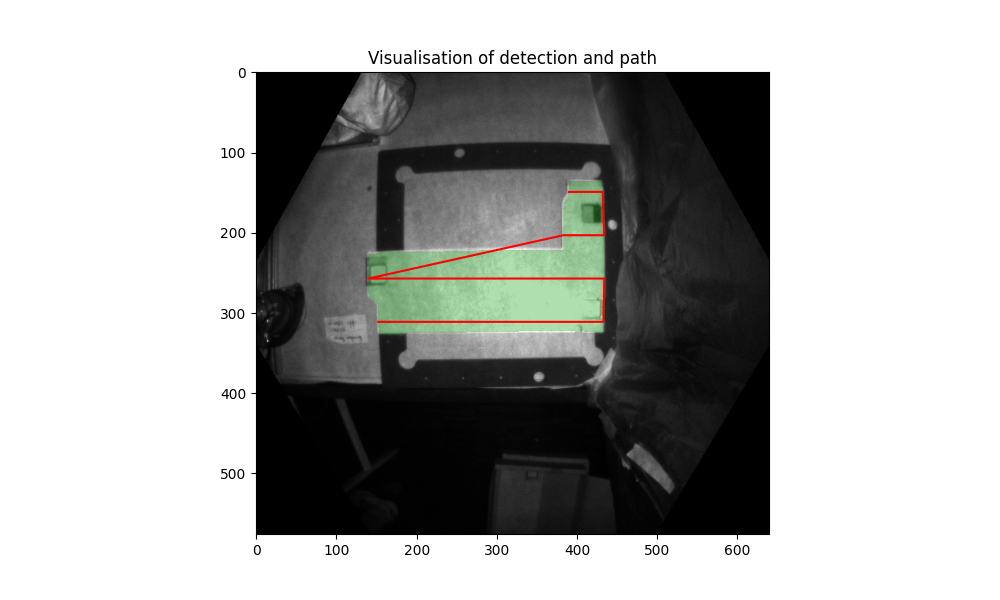

Stride adjusted for: -7.0 %


<IPython.core.display.Javascript object>


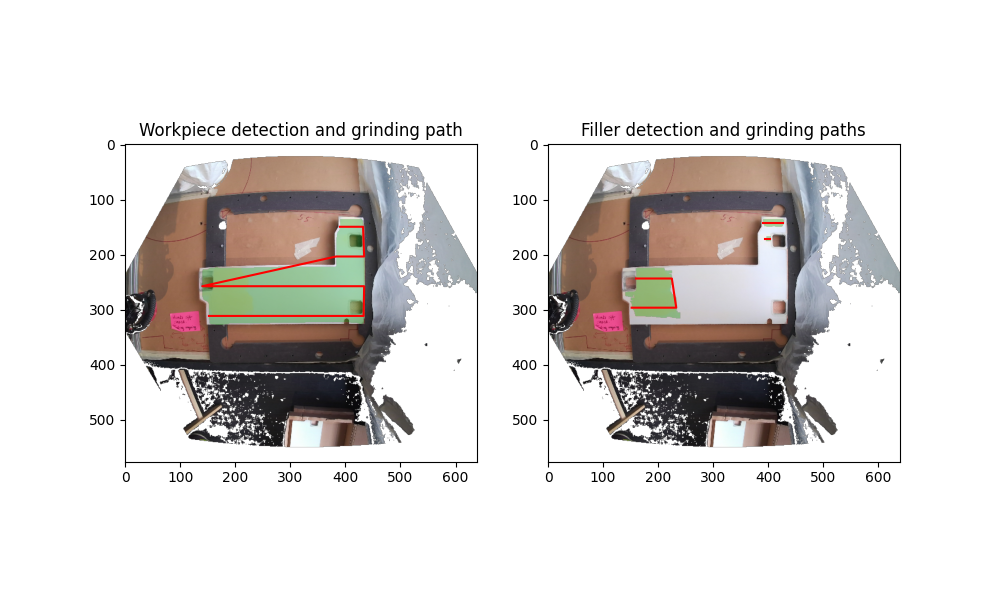

<IPython.core.display.Javascript object>


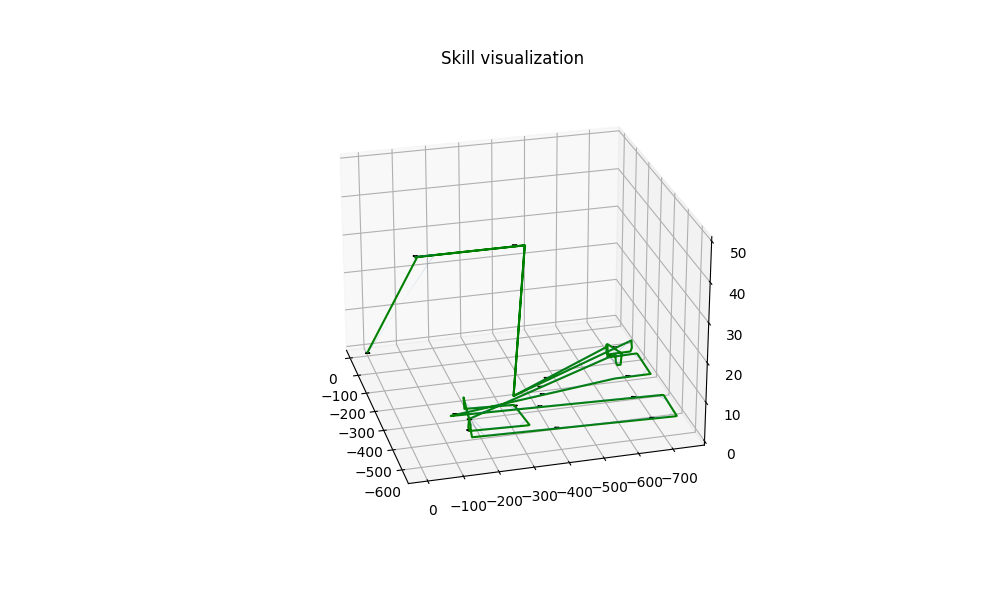

len poses: 4
4
robot cell is probably not initialized. Would set digital_out[0] to False
robot cell is probably not initialized. Would set digital_out[1] to True
Wait for 500 ms
robot cell is probably not initialized. Would set digital_out[0] to False
robot cell is probably not initialized. Would set digital_out[1] to False
robot cell is probably not initialized. Would set digital_out[0] to False
robot cell is probably not initialized. Would set digital_out[1] to True
Wait for 500 ms
robot cell is probably not initialized. Would set digital_out[0] to False
robot cell is probably not initialized. Would set digital_out[1] to False
robot cell is probably not initialized. Would set digital_out[0] to False
robot cell is probably not initialized. Would set digital_out[1] to True
Wait for 500 ms
robot cell is probably not initialized. Would set digital_out[0] to False
robot cell is probably not initialized. Would set digital_out[1] to False
robot cell is probably not initialized. Would set di

In [98]:
# Set fig size:
plt.rcParams['figure.figsize'] = [10, 6]

# Capture an image of workpiece
if kinect is not None:
    sCapture2 = takeCapture(kinect)
else:
    print("Trying to use saved capture.")

    
@register_builtin_func
def grinding_tool(state):
    '''grinding on/off. (1 or 0)'''
    
    if tool_on:
        write_io('digital_out[0]', state)
    else:
        write_io('digital_out[0]', False)
    write_io('digital_out[1]', state)
    

def write_io(io_name, value):
    try :
        robot_cell.io[io_name] = bool(value)
    except:
        print(f'robot cell is probably not initialized. Would set {io_name} to {bool(value)}')
    
    
def detectAndGenerate(showPreview=False, true_grinding_height=False):
    
    # Settings:
    objectThickness = 30 # Todo: make this thresholding a little smarter
    tool_diameter = 160
    tool_grinding_ovelap = 0.25*tool_diameter
    
    travel_z_offset = 3
    grinding_z_offset = -10
    
    if true_grinding_height:
        z_offset_path = grinding_z_offset
    else:
        z_offset_path = 0
    
    # Vars that need to be Arguments:
    ''' H_CR, sCaptures?
    
    '''
    # Code: ________________________________________________________
    mask, stridePixels = differenceMask(sCapture1.depth, sCapture2.depth, 
                                        objectThickness=objectThickness,
                                        tool_diameter=tool_diameter,
                                        stride_overlap=tool_grinding_ovelap,
                                        image_w_object=sCapture2.ir, 
                                        showPreview=showPreview, 
                                        maxIrValue=maxIrValue)

    mask = improveMask(sCapture2, mask, H_CR, showPreview=showPreview)
    
    fillPattern = generate_path_improved_coverage(mask, stridePixels, 
                                                  start_from_edge_ratio=1/4, 
                                                  showPreview=showPreview)

    visualiseOnImage(sCapture2.ir, mask, path=fillPattern, maxIrValue=maxIrValue)
    
    path3D_RS = depth2robotCS(sCapture2, fillPattern, H_CR, 
                              showPreview=showPreview)
    
    path3D_RS, object_z = improvePathAccuracy(sCapture2, path3D_RS, 
                                    fillPattern, H_CR, mask, 
                                    objectThickness, 
                                    showPreview=showPreview,
                                    showDebugPreview=False)
    
    # Collect all grinding paths 
    allPaths_3D_RS = []
    allPaths_3D_RS.append(path3D_RS)
    # fill patterns for filler: 
    fillPatterns_filler_list = []
    
    # ### Filler things:
     
    img = sCapture2.color_depth2d
    # TODO: we need a list of 'masks' - each contour is it's own mask:
    list_of_masks_filler = recognize_filled_area(img, showPreview=showPreview, 
                                                 mask_workpiece=mask)

    # TODO: a loop over all masks
    for mask_filler in list_of_masks_filler:
        fillPattern_filler = generate_path_improved_coverage(mask_filler, stridePixels, 
                                                      start_from_edge_ratio=1/3, 
                                                      showPreview=showPreview)
        fillPatterns_filler_list.append(fillPattern_filler)
        path3D_RS_filler = depth2robotCS(sCapture2, fillPattern_filler, H_CR, 
                                  showPreview=showPreview)
        path3D_RS_filler[:,2] = object_z
        allPaths_3D_RS.append(path3D_RS_filler)
        
    # TODO: New function? supporting list of paths?
#         visualiseOnImage(img, mask_filler, path=fillPattern_filler, maxIrValue=maxIrValue)
    # @@@@@@@@@@@@@2 LAST TODO: this visualisation. and clean up the rest. 
    #but should work already
    visualise_grinding(img, mask_grinding=mask, 
                       path_grinding=fillPattern,
                       masks_filler=list_of_masks_filler, 
                       paths_filler=fillPatterns_filler_list)
    
#     code = generateWS_code(path3D_RS, z_offset_path=z_offset_path, 
#                            z_offset_travel=travel_z_offset)
    code = generateWS_code_generalized(allPaths_3D_RS, z_offset_path=z_offset_path, 
                           z_offset_travel=travel_z_offset)
    
    return code, path3D_RS, travel_z_offset

### Settings:
tool_on = False # Must remain False for the simulation (otherwise tool goes on)

# Toggle for the grinding or previewing height:
true_grinding_height = [False, True][0]

###

code, path3D_RS, travel_z_offset = detectAndGenerate(showPreview=False, 
                                    true_grinding_height=true_grinding_height)


In [54]:
a = np.zeros((5,3))
b = np.ones([7,3])
print(np.concatenate((a,b)))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [37]:
import matplotlib.pyplot as plt

hdata = np.random.random(20)
x = plt.hist(hdata)
y = plt.hist(hdata, bins=40)
print(x)

(array([1., 4., 1., 1., 3., 1., 3., 1., 1., 4.]), array([0.03052887, 0.11616324, 0.2017976 , 0.28743197, 0.37306633,
       0.4587007 , 0.54433506, 0.62996943, 0.71560379, 0.80123816,
       0.88687252]), <BarContainer object of 10 artists>)


In [36]:
from wandelscript.metamodel import Store, MotionCollector
from wandelpy.robotcell import Robot, RobotCell

robot = Robot.from_ip("192.168.101.1") # EFW sojka cell
# robot = Robot.from_ip("172.30.1.80")
robot_cell = RobotCell(
    robot=robot,
    io=robot.io,
)
print('robot_cell initialized.')

robot_cell initialized.


In [37]:
robot_cell.get_state()

RobotState(pose=([-499.0847168 ,  385.69262695,  382.46289062], [ 0.00955451,  0.93154467, -0.35822213, -0.06172635]))

In [20]:
### _______ WARNING: The code below will move the robot! __________________________
# The cell executes the grinding application - based on the code generated
# in the cells above.

# Preview means tool will not be on.
tool_on = [False, True][0]


# Robot Motion:
store = Store(MotionCollector(robot_cell))
Skill.from_code(code)(store)

NameError: name 'robot_cell' is not defined

In [39]:
# _______ Additional code for movement ____________________________________
code_move2point = """
def grinding_tool_sync(state):
    sync
    grinding_tool(state)


home := [-580, 100, 50, 3.14, 0, 0.0]
point := [-580, 0, 50, 3.14, 0, 0.0]

grinding_tool_sync(0)


move via p2p() to home

move via line() to point

grinding_tool_sync(1)


move via line() to [0, 30, 0, 0, 0, 0] :: point
grinding_tool_sync(0)



move via line() to home
"""

tool_on = False

code = code_move2point

store = Store(MotionCollector(robot_cell))
Skill.from_code(code)(store)

finished
finished
finished


In [32]:
# ----------------------------------------------------------
from wandelscript.metamodel import Store, MotionCollector
from wandelpy.robotcell import Robot, RobotCell

robot = Robot.from_ip("192.168.101.1") # EFW sojka cell
# robot = Robot.from_ip("172.30.1.80")  # Sonny RS
robot_cell = RobotCell(
    robot=robot,
    io=robot.io,
)
print('robot_cell initialized.')

robot_cell initialized.


In [33]:
io = robot_cell.io
# io??

print(io.keys())
print(io['digital_out[0]'])
robot_cell.io['digital_out[0]'] = True
print(io['digital_out[0]'])

['analog_in[0]', 'analog_in[1]', 'analog_in[2]', 'analog_in[3]', 'analog_out[0]', 'analog_out[1]', 'config_in[0]', 'config_in[1]', 'config_in[2]', 'config_in[3]', 'config_in[4]', 'config_in[5]', 'config_in[6]', 'config_in[7]', 'config_out[0]', 'config_out[1]', 'config_out[2]', 'config_out[3]', 'config_out[4]', 'config_out[5]', 'config_out[6]', 'config_out[7]', 'digital_in[0]', 'digital_in[1]', 'digital_in[2]', 'digital_in[3]', 'digital_in[4]', 'digital_in[5]', 'digital_in[6]', 'digital_in[7]', 'digital_out[0]', 'digital_out[1]', 'digital_out[2]', 'digital_out[3]', 'digital_out[4]', 'digital_out[5]', 'digital_out[6]', 'digital_out[7]', 'tool_in[0]', 'tool_in[1]', 'tool_out[0]', 'tool_out[1]']
False
True


In [194]:
#########################################################################################
#########################################################################################
#########################################################################################
_ = [print(110*'#') for i in range(3)]

##############################################################################################################
##############################################################################################################
##############################################################################################################


In [39]:
#########################################################################################
# Developmental code:

showPreview=False
true_grinding_height=False
    
# Settings:
objectThickness = 30 # Todo: make this thresholding a little smarter
tool_diameter = 153
tool_grinding_ovelap = 0.25*tool_diameter

travel_z_offset = 3
grinding_z_offset = -10

if true_grinding_height:
    z_offset_path = grinding_z_offset
else:
    z_offset_path = 0

# Vars that need to be Arguments:
''' H_CR, sCaptures?

'''
# Code: ________________________________________________________
mask, stridePixels = differenceMask(sCapture1.depth, sCapture2.depth, 
                                    objectThickness=objectThickness,
                                    tool_diameter=tool_diameter,
                                    stride_overlap=tool_grinding_ovelap,
                                    image_w_object=sCapture2.ir, 
                                    showPreview=showPreview, 
                                    maxIrValue=maxIrValue)

mask = improveMask(sCapture2, mask, H_CR, showPreview=showPreview)



#     fillPattern = generate_path(mask, stridePixels)
fillPattern = generate_path_improved_coverage(mask, stridePixels)

999.7773280506228
cut_off_z 5.947893701180021


Stride adjusted for: 0.0 %


<IPython.core.display.Javascript object>


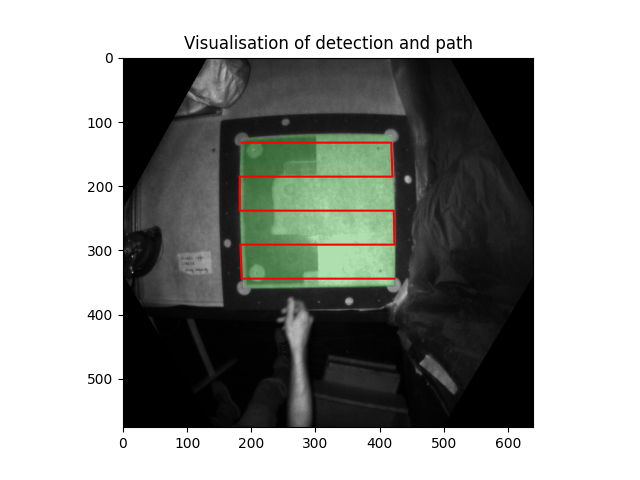

<IPython.core.display.Javascript object>


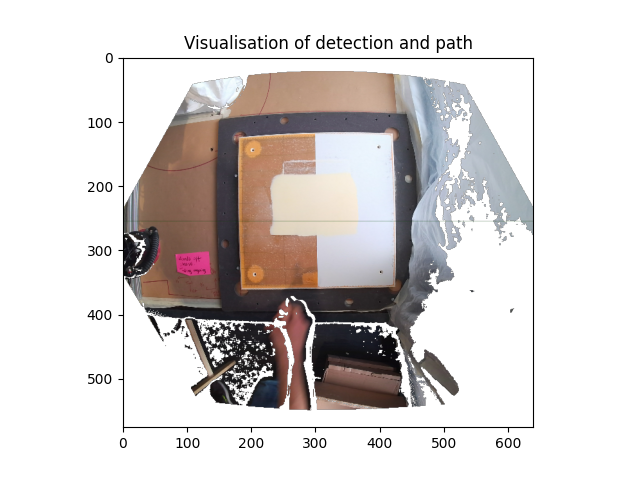

<IPython.core.display.Javascript object>


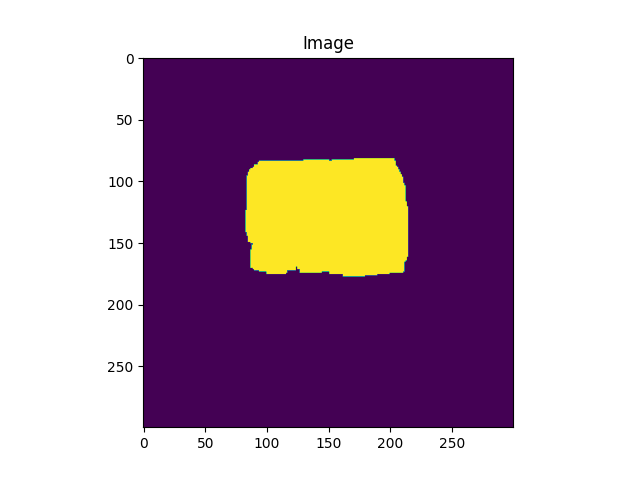

uint8


In [262]:
#########################################################################################
# Developmental code:

showPreview=False
true_grinding_height=False
    
# Settings:
objectThickness = 30 # Todo: make this thresholding a little smarter
tool_diameter = 150
tool_grinding_ovelap = 0.25*tool_diameter

travel_z_offset = 3
grinding_z_offset = -10

if true_grinding_height:
    z_offset_path = grinding_z_offset
else:
    z_offset_path = 0

# Vars that need to be Arguments:
''' H_CR, sCaptures?

'''
# Code: ________________________________________________________
mask, stridePixels = differenceMask(sCapture1.depth, sCapture2.depth, 
                                    objectThickness=objectThickness,
                                    tool_diameter=tool_diameter,
                                    stride_overlap=tool_grinding_ovelap,
                                    image_w_object=sCapture2.ir, 
                                    showPreview=showPreview, 
                                    maxIrValue=maxIrValue)

mask = improveMask(sCapture2, mask, H_CR, showPreview=showPreview)



#     fillPattern = generate_path(mask, stridePixels)
fillPattern = generate_path_improved_coverage(mask, stridePixels, showPreview=showPreview)


visualiseOnImage(sCapture2.ir, mask, path=fillPattern, maxIrValue=maxIrValue)

visualiseOnImage(sCapture2.color_depth2d, mask_filler)

plot_img(mask_filler)
print(mask_filler.dtype)

In [232]:
def plot_img(img, title='Image'):
    plt.figure()
    plt.imshow(img)
    plt.title(title)
    
def plot_2_img(img1, img2, title='comparison'):
    plt.figure()
    plt.title(title)
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    
    

<IPython.core.display.Javascript object>


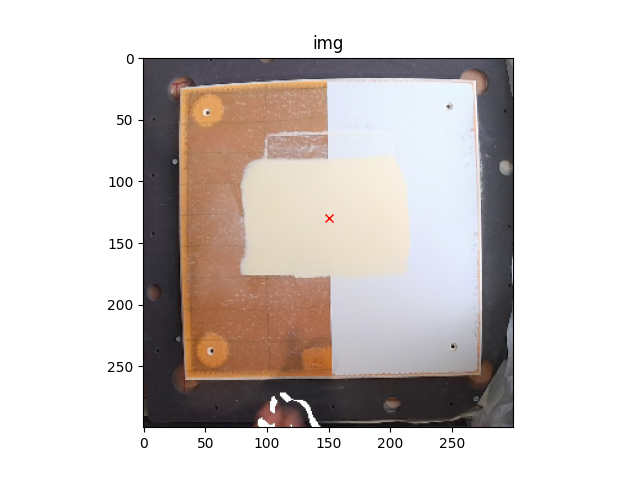

In [265]:
import cv2

ref_point = [130, 150] # in pixel coordinates


img = sCapture2.color_depth2d[100:400, 150:450].copy()
plot_img(img, 'img')
plt.plot(ref_point[1], ref_point[0], 'rx')

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
showHSV = False
if showHSV:
    plot_img(img_hsv[:,:,0], 'img_hsv - h')
    plot_img(img_hsv[:,:,1], 'img_hsv - s')
    plot_img(img_hsv[:,:,2], 'img_hsv - v')




hsv values for ref_point:
[ 17  31 238]


<IPython.core.display.Javascript object>


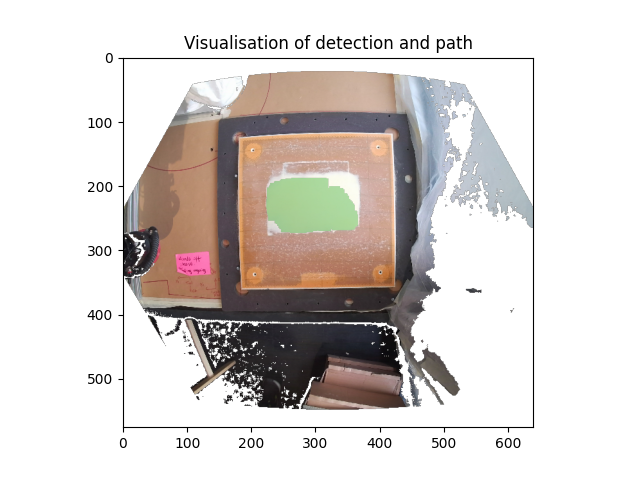

In [280]:
print('hsv values for ref_point:')
print(filler_hsv := img_hsv[ref_point[0], ref_point[1]])
window = 17
filler_hsv_low = filler_hsv - window
filler_hsv_high = filler_hsv + window

def recognize_filled_area(img, showPreview=False):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(img_hsv, filler_hsv_low, filler_hsv_high)

    if showPreview:
        plot_img(mask, 'from hsv range')

    mask = morphology_open(mask, 15)
    mask = mask.astype(bool)

    if showPreview:
        plot_img(mask, 'hsv range and open')

    if showPreview:
        plot_2_img(img, mask)

    if showPreview:
        visualiseOnImage(img, mask=mask)
        
    return mask


recognize_filled_area(img)
visualiseOnImage(img, mask=mask)

In [43]:



# Test on some more images:

fileNames = []
# fileNames.append('05_Cockpit_FS_4.pkl')      # cockpit front side part 4
# fileNames.append('05_Cockpit_5.pkl')      # cockpit rear side
fileNames.append('04_Tedlar_GFK_2.pkl')      # 
fileNames.append('04_Tedlar_GFK_3.pkl')
fileNames.append('GFK_2.pkl')   
fileNames.append('02_Tedlar_2.pkl')   


for fileLoad in fileNames:
    with open(fileLoad, 'rb') as fileIn:
        sCapture1, sCapture2 = pickle.load(fileIn)
        
        img = sCapture2.color_depth2d
        mask = recognize_filled_area(img)
                
        visualiseOnImage(img, mask=mask)

NameError: name 'recognize_filled_area' is not defined